# Auto crop and split objects into 4 sub-images
**Pipeline:**

1. Load image via coco api
2. Get bounding box of objects
3. Create 4 sub-images with object allocated to each corner
4. Apply prediction to sub_images
5. Save results to json format for further analysis
6. Save sub_images to local storage with prediction results (label + bbox)
- folder named as associated category
- sub_images file name have suffix as _1, _2, _3, _4

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
traffic light 70.26870846748352


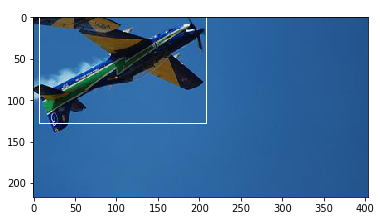

In [1]:
# Load libraries
%matplotlib inline
from make_show_result import *
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import torchvision.transforms.functional as TF
import PIL
import os
import json 
from urllib.request import urlretrieve
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
# Define image directory
projectDir=os.getcwd()
dataDir='.'
dataType='val2017'
imageDir='{}/images/'.format(dataDir)
annFile='{}/images/{}_selected/annotations/instances_{}.json'.format(dataDir,dataType,dataType)

## 1. Load image via coco api

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile); print()

# display COCO categories 
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

# display COCO supercategories
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!

COCO categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush

COCO supercategories: 
accessory vehicle indoor sports electronic kitchen animal appliance food person furniture outdoor


**Test loading 1 specific image / category**

In [4]:
def load_coco_img(idNumber):
    """Returns a single image with corresponding ID.
    """
    imID = coco.getImgIds(imgIds = int(idNumber))
    imInfo = coco.loadImgs(imID)[0]
    I = io.imread(imInfo['coco_url'])
    return I

def load_coco_cat(catName):
    """Returns a list of image id of a single category.
    """
    catIds = coco.getCatIds(catNms=catName);
    imIds = coco.getImgIds(catIds=catIds)
    return imIds

In [5]:
# Test function load_coco_cat
imgIds_list = load_coco_cat("airplane")
print(imgIds_list)

[208901, 90631, 525322, 452122, 400922, 71711, 13348, 513580, 408112, 524850, 39484, 379453, 502347, 114770, 579158, 196185, 205401, 281693, 139871, 396903, 44652, 410221, 442480, 300659, 167540, 323709, 545407, 110721, 520324, 383621, 553094, 567432, 478862, 404128, 456865, 388258, 479912, 272049, 469174, 52412, 214205, 463037, 504000, 381639, 459467, 183500, 348881, 190676, 98520, 137950, 1761, 575205, 493286, 134886, 99054, 144114, 477441, 425221, 272136, 84752, 161044, 110359, 392481, 96549, 543528, 199977, 52017, 131386, 502599, 424776, 109900, 488270, 208208, 500049, 33114, 384350, 187745, 5477, 229747, 485237, 22396, 189828, 517523, 338325, 101787, 497568, 163746, 485802, 490413, 336309, 449996, 293324, 495054, 571857, 217060, 135673, 404479]


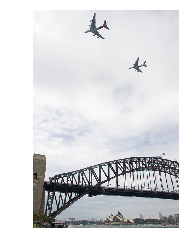

In [6]:
# Test function load_coco_img
I = load_coco_img(1761)
plt.axis('off')
plt.imshow(I)
plt.show()

## 2. Get bounding box of object

In [5]:
def get_category_dictionary1():
    catLblFile='{}/images/val2017_selected/annotations/coco-labels-paper.txt'.format(dataDir)
    f = open(catLblFile, "r")
    category_name = list()
    for cat in f:
        category_name.append(cat)
    cat_dict = {category_name[i - 1].strip("\n"): i for i in range(1, len(category_name)+1)}
    return cat_dict

def get_category_dictionary2():
    catLblFile='{}/images/val2017_selected/annotations/coco-labels-paper.txt'.format(dataDir)
    f = open(catLblFile, "r")
    category_name = list()
    for cat in f:
        category_name.append(cat)
    cat_dict = {i: category_name[i - 1].strip("\n") for i in range(1, len(category_name)+1)}
    return cat_dict

def load_coco_anns(idNumber, catName):
    """Returns all annotation information of a specific image and associated category of objects existing in that image.
    """
    annIds = coco.getAnnIds(imgIds=idNumber, iscrowd=None)
    anns = coco.loadAnns(annIds)
    anns_cat = []
    catDict = get_category_dictionary1()
    for ann in anns:
        if (ann["category_id"] == catDict[catName]):
            anns_cat.append(ann)
    return anns_cat

In [8]:
print(get_category_dictionary1())
print(get_category_dictionary2())

{'suitcase': 33, 'horse': 19, 'cup': 47, 'train': 7, 'tv': 72, 'dining table': 67, 'vase': 86, 'bench': 15, 'cow': 21, 'wine glass': 46, 'hair brush': 91, 'baseball glove': 40, 'plate': 45, 'blender': 83, 'bed': 65, 'elephant': 22, 'pizza': 59, 'cell phone': 77, 'cat': 17, 'broccoli': 56, 'eye glasses': 30, 'kite': 38, 'bicycle': 2, 'hat': 26, 'sheep': 20, 'apple': 53, 'window': 68, 'orange': 55, 'dog': 18, 'teddy bear': 88, 'backpack': 27, 'frisbee': 34, 'fire hydrant': 11, 'sports ball': 37, 'spoon': 50, 'oven': 79, 'bowl': 51, 'motorcycle': 4, 'desk': 69, 'clock': 85, 'bottle': 44, 'refrigerator': 82, 'door': 71, 'remote': 75, 'parking meter': 14, 'street sign': 12, 'sink': 81, 'bird': 16, 'knife': 49, 'truck': 8, 'potted plant': 64, 'toothbrush': 90, 'stop sign': 13, 'airplane': 5, 'bus': 6, 'banana': 52, 'microwave': 78, 'chair': 62, 'snowboard': 36, 'tie': 32, 'umbrella': 28, 'handbag': 31, 'shoe': 29, 'boat': 9, 'toaster': 80, 'laptop': 73, 'mouse': 74, 'skis': 35, 'couch': 63, 

In [9]:
# Test load_coco_anns on single image_id
selected_image_anns = load_coco_anns([1761], 'airplane')
print(selected_image_anns)

# Test load_coco_anns on list of image_id
# selected_image_anns = load_coco_anns(imgIds_list, 'airplane')
# print(selected_image_anns)

[{'category_id': 5, 'iscrowd': 0, 'image_id': 1761, 'bbox': [282.23, 139.38, 51.22, 43.78], 'segmentation': [[282.23, 172.01, 291.32, 167.05, 295.04, 162.51, 292.97, 160.85, 295.86, 158.38, 299.99, 154.66, 296.28, 153.42, 301.65, 150.12, 309.49, 139.38, 305.78, 160.44, 307.43, 165.81, 309.08, 162.09, 319.41, 159.2, 328.49, 150.12, 328.9, 161.68, 333.45, 168.29, 324.36, 164.16, 321.47, 164.16, 308.25, 167.88, 306.6, 172.01, 318.58, 183.16, 309.49, 180.27, 303.71, 182.33, 305.78, 177.79, 303.3, 176.96, 297.93, 177.79, 301.65, 176.14, 296.69, 171.59, 284.3, 171.18]], 'area': 567.9410999999999, 'id': 159605}, {'category_id': 5, 'iscrowd': 0, 'image_id': 1761, 'bbox': [150.17, 8.63, 74.09, 77.19], 'segmentation': [[150.17, 65.64, 154.39, 61.87, 166.81, 58.98, 170.14, 47.0, 165.26, 48.56, 163.93, 47.0, 170.8, 43.01, 172.58, 32.81, 168.81, 34.58, 167.48, 32.81, 173.69, 28.59, 178.35, 11.73, 183.0, 8.63, 183.0, 52.11, 195.87, 47.23, 199.42, 46.56, 205.63, 45.23, 209.62, 31.03, 213.62, 28.37, 2

## 3. Create 4 sub-images

1. Create category folder if not exist
2. Create image_id folder if not exist
3. Crop image_1/2/3/4
4. Save image_1/2/3/4
5. Create summary.csv

In [6]:
def create_category_folder(category):
    """Creates a folder named as category in ./images/ directory
       and returns a new path
    """
    imageDir='./images/'
    path = os.path.join(imageDir, category)
    try:
        if not (os.path.exists(path)):
            os.mkdir(path) 
    except OSError as error: 
        pass  
    return path

def create_imageID_folder(category_folder, image_id):
    path = os.path.join(category_folder, str(image_id))
    try: 
        if not (os.path.exists(path)):
            os.mkdir(path) 
    except OSError as error: 
        pass  
    return path

In [7]:
def download_coco_image(image_id, image_cat):
    """
    """
    # Create directory
    catDir = create_category_folder(image_cat)
    imgDir = create_imageID_folder(catDir, image_id)

    # Download image
    imgInfo = coco.loadImgs(image_id)[0]
    file_name = imgInfo['file_name']
    path = os.path.join(imgDir, imgInfo['file_name'])
    if not os.path.exists(path):
        coco.download(tarDir = imgDir, imgIds = [image_id])
    
    return path, imgDir

In [12]:
new_path, _ = download_coco_image(1761, 'airplane')
print(new_path)

downloaded 0/1 images (t=1.5s)
./images/airplane/1761/000000001761.jpg


In [8]:
def transform_bbox_coordinate(corner, bbox):
    corner_x, corner_y = corner.copy()
    x, y, w, h = map(round,bbox)
    new_x = (1 - corner_x) * x
    new_y = (1 - corner_y) * y
    return new_x, new_y, w, h

def transform_image_coordinate(corner, bbox, image_size):
    corner_x, corner_y = corner
    x, y, w, h = map(round,bbox)
    im_w, im_h = image_size
    new_x = corner_x * x
    new_y = corner_y * y
    new_h = corner_y * (im_h - y) + (1 - corner_y) * (y + h)
    new_w = corner_x * (im_w - x) + (1 - corner_x) * (x + w)
    return new_x, new_y, new_w, new_h

def generate_corner_objects(image_anns, return_image=False):
    """Reads info from 1 image's annotation and returns 2 parameters: 
    """
    catDict = get_category_dictionary2()
    imgDir, imgFolder = download_coco_image(
        image_anns['image_id'],
        catDict[image_anns['category_id']])
    img = PIL.Image.open(imgDir)

    # Crop sub-images
    corners = [[0,0], [0,1], [1,0], [1,1]]
    object_list = list()
    test_images = list()
    for idx, corner in enumerate(corners):
        _x, _y, _w, _h = transform_image_coordinate(corner, image_anns['bbox'], img.size)
        test_image = TF.crop(img, _y, _x, _h, _w)
        object_name = str(image_anns['id'])+'_'+str(idx)+'.jpg'
        test_image.save(os.path.join(imgFolder,object_name), "JPEG")
        test_images.append(test_image)

        #Create object_info
        object_info = dict()
        object_info['path'] = imgFolder
        object_info['filename'] = object_name
        object_info['bbox'] = list(transform_bbox_coordinate(corner, image_anns['bbox']))
        object_info['category'] = catDict[image_anns['category_id']]
        object_info['width'] = test_image.width
        object_info['height'] = test_image.height
        object_list.append(object_info)

    # Create object_id.csv file
    obj_df = pd.DataFrame(object_list)
    os.rename(imgDir, os.path.join(imgFolder, str(image_anns['id'])+'.jpg'))
    obj_df = obj_df.append({
        'bbox': list(map(int,image_anns['bbox'])),
        'category': catDict[image_anns['category_id']],
        'filename': str(image_anns['id'])+'.jpg',
        'path': imgFolder,
        'width': img.width,
        'height': img.height,
    }, ignore_index=True)

    obj_df.to_csv(os.path.join(imgFolder, str(image_anns['id']))+'.csv', header=True, index=False)
    
    if return_image:
        return test_images
    else:    
        return

downloaded 0/1 images (t=1.5s)


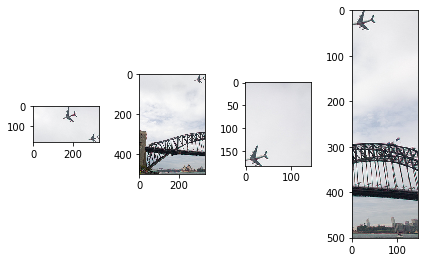

downloaded 0/1 images (t=1.3s)


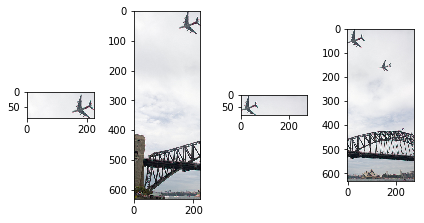

In [28]:
selected_image_anns = load_coco_anns([1761], 'airplane') #1761
for ann in selected_image_anns:
    new_images = generate_corner_objects(ann, return_image=True)
    im1, im2, im3, im4 = new_images
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(np.asarray(im1))
    axs[1].imshow(np.asarray(im2))
    axs[2].imshow(np.asarray(im3))
    axs[3].imshow(np.asarray(im4))
    fig.tight_layout()
    plt.show()

## 4. Automate cropping image

In [28]:
def qualified_crop(obj_ann):
    x, y, w, h = map(round,obj_ann['bbox'])
    resolution_threshold = 28*28
    if w*h >= resolution_threshold:
        center_x, center_y = x+w/2, y+h/2
        imgInfo = coco.loadImgs(obj_ann['image_id'])[0]
        img_w, img_h = imgInfo['width'], imgInfo['height']
        # if (center_x >= img_w/3) and (center_x <= 2*img_w/3):
        #     if (center_y >= img_h/3) and (center_y <= 2*img_h/3):
        return True
    return False

In [29]:
# Load specific category
selected_category = "book"
imgIds_list = load_coco_cat(selected_category)

# Get all objects belong to that category
objAnns = load_coco_anns(imgIds_list, selected_category)
print('Total objects: {}'.format(len(objAnns)))

# Select certain number of object
selected_image_ids = []
for idx, ann in enumerate(objAnns):
    # print(ann)
    if len(selected_image_ids) >= 100:
        break
    if ann['image_id'] not in selected_image_ids:
        if qualified_crop(ann):
            generate_corner_objects(ann)
            selected_image_ids.append(ann['image_id'])


Total objects: 1161
downloaded 0/1 images (t=2.5s)
downloaded 0/1 images (t=1.6s)
downloaded 0/1 images (t=1.4s)
downloaded 0/1 images (t=1.3s)
downloaded 0/1 images (t=1.5s)
downloaded 0/1 images (t=1.5s)
downloaded 0/1 images (t=1.5s)
downloaded 0/1 images (t=1.3s)
downloaded 0/1 images (t=1.8s)
downloaded 0/1 images (t=1.8s)
downloaded 0/1 images (t=1.0s)
downloaded 0/1 images (t=1.9s)
downloaded 0/1 images (t=1.5s)
downloaded 0/1 images (t=1.7s)
downloaded 0/1 images (t=1.4s)
downloaded 0/1 images (t=1.3s)
downloaded 0/1 images (t=1.3s)
downloaded 0/1 images (t=1.7s)
downloaded 0/1 images (t=1.6s)
downloaded 0/1 images (t=1.8s)
downloaded 0/1 images (t=1.5s)
downloaded 0/1 images (t=1.8s)
downloaded 0/1 images (t=1.4s)
downloaded 0/1 images (t=1.3s)
downloaded 0/1 images (t=1.6s)
downloaded 0/1 images (t=1.4s)
downloaded 0/1 images (t=1.7s)
downloaded 0/1 images (t=2.3s)
downloaded 0/1 images (t=1.8s)
downloaded 0/1 images (t=1.2s)
downloaded 0/1 images (t=1.3s)
downloaded 0/1 imag

## 5. Gather all csv files

In [30]:
all_files = []
for subdir, dirs, files in os.walk(os.path.join(imageDir,selected_category)):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".csv"):
            all_files.append(filepath)
            print(filepath)

./images/book/529148/1139919.csv
./images/book/344621/1139063.csv
./images/book/112798/1985721.csv
./images/book/385719/1139451.csv
./images/book/389315/1652379.csv
./images/book/368684/1145116.csv
./images/book/506933/1147645.csv
./images/book/166478/1138070.csv
./images/book/206579/1986194.csv
./images/book/96001/1137334.csv
./images/book/167159/1137818.csv
./images/book/551439/1140019.csv
./images/book/16958/1144744.csv
./images/book/458255/1141588.csv
./images/book/172617/1140850.csv
./images/book/334399/1648816.csv
./images/book/14038/2197005.csv
./images/book/250901/1986136.csv
./images/book/25603/1144688.csv
./images/book/172595/1139612.csv
./images/book/421923/1137283.csv
./images/book/222299/1648151.csv
./images/book/413247/1139762.csv
./images/book/398377/1138534.csv
./images/book/509699/1141405.csv
./images/book/415741/1648882.csv
./images/book/472678/1648320.csv
./images/book/575187/1145126.csv
./images/book/55528/1647877.csv
./images/book/467176/908400467176.csv
./images/b

In [31]:
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df_images = pd.concat(li, axis=0, ignore_index=True)

In [32]:
df_images.head(12)

,bbox,category,filename,height,path,width
0,"[271, 117, 36, 23]",book,1139919_0.jpg,140,./images/book/529148,307
1,"[271, 0, 36, 23]",book,1139919_1.jpg,309,./images/book/529148,307
2,"[0, 117, 36, 23]",book,1139919_2.jpg,140,./images/book/529148,369
3,"[0, 0, 36, 23]",book,1139919_3.jpg,309,./images/book/529148,369
4,"[270, 116, 35, 22]",book,1139919.jpg,426,./images/book/529148,640
5,"[239, 241, 55, 24]",book,1139063_0.jpg,265,./images/book/344621,294
6,"[239, 0, 55, 24]",book,1139063_1.jpg,92,./images/book/344621,294
7,"[0, 241, 55, 24]",book,1139063_2.jpg,265,./images/book/344621,261
8,"[0, 0, 55, 24]",book,1139063_3.jpg,92,./images/book/344621,261
9,"[238, 241, 54, 23]",book,1139063.jpg,333,./images/book/344621,500


In [33]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
bbox        500 non-null object
category    500 non-null object
filename    500 non-null object
height      500 non-null int64
path        500 non-null object
width       500 non-null int64
dtypes: int64(2), object(4)
memory usage: 23.6+ KB
